### Module Import

In [1]:
pip install folium html5lib

     |████████████████████████████████| 92kB 300kB/s eta 0:00:01
     |████████████████████████████████| 122kB 1.0MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import folium
from folium.plugins import MarkerCluster
import requests
import pandas as pandas
import numpy as numpy
import re
import html5lib
from datetime import datetime
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plot
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [5]:
# Lets load our dataset and look at the first few data point.

In [3]:
input_file = "globalterrorismdb_0919csv.csv"
global_terrorism_data = pandas.read_csv(input_file)
global_terrorism_data.head(10)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN
6,197001020001,1970,1,2,NaN,0,NaN,218,Uruguay,3,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,"Damages were estimated to be between $20,000-$...",Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,The New Years Gang issue a communiqué to a loc...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN
9,197001030001,1970,1,3,NaN,0,NaN,217,United States,1,...,"Karl Armstrong's girlfriend, Lynn Schultz, dro...",Committee on Government Operations United Stat...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...",Hewitt Project,0,0,0,0,NaN


This is a large dataset. There are several missing data and data points we won't use. First, we define the columns we need and pull then from the data. 

In [4]:
columns_needed = ["iyear", "imonth", "iday", "country", "country_txt", "region", "region_txt", "provstate",
                  "city", "latitude", "longitude", "targtype1", "targtype1_txt", "attacktype1",
                  "attacktype1_txt", "success", "nkill", "nwound", "gname", "claimed", "weaptype1", "weaptype1_txt"]

# Using pandas dataframe to create new dataframe from our previos one. 
global_terrorism_data = pandas.DataFrame(global_terrorism_data, columns = columns_needed)

# Drop rows with any NaN year in the selected columns only
global_terrorism_data = global_terrorism_data.dropna(how='any', subset=['latitude', 'longitude', "iyear"])

#global_terrorism_data = global_terrorism_data.dropna()
# lets take a look now
global_terrorism_data.head()

,iyear,imonth,iday,country,country_txt,region,region_txt,provstate,city,latitude,...,targtype1_txt,attacktype1,attacktype1_txt,success,nkill,nwound,gname,claimed,weaptype1,weaptype1_txt
0,1970,7,2,58,Dominican Republic,2,Central America & Caribbean,National,Santo Domingo,18.456792,...,Private Citizens & Property,1,Assassination,1,1.0,0.0,MANO-D,NaN,13,Unknown
1,1970,0,0,130,Mexico,1,North America,Federal,Mexico city,19.371887,...,Government (Diplomatic),6,Hostage Taking (Kidnapping),1,0.0,0.0,23rd of September Communist League,NaN,13,Unknown
2,1970,1,0,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,...,Journalists & Media,1,Assassination,1,1.0,0.0,Unknown,NaN,13,Unknown
3,1970,1,0,78,Greece,8,Western Europe,Attica,Athens,37.997490,...,Government (Diplomatic),3,Bombing/Explosion,1,NaN,NaN,Unknown,NaN,6,Explosives
4,1970,1,0,101,Japan,4,East Asia,Fukouka,Fukouka,33.580412,...,Government (Diplomatic),7,Facility/Infrastructure Attack,1,NaN,NaN,Unknown,NaN,8,Incendiary


In [5]:
# Lets get the count of recorded attach for each year.

In [6]:
global_terrorism_year_counts = global_terrorism_data.groupby('iyear').size().reset_index(name='attack_counts')

In [7]:
# Lets look at the size of the output.
global_terrorism_year_counts.shape
#global_terrorism_year_counts.describe()

(48, 2)

In [8]:
# Now lets take a look at the data.
global_terrorism_year_counts.head()

,iyear,attack_counts
0,1970,643
1,1971,463
2,1972,551
3,1973,465
4,1974,577


Lets plot the result to take better look.

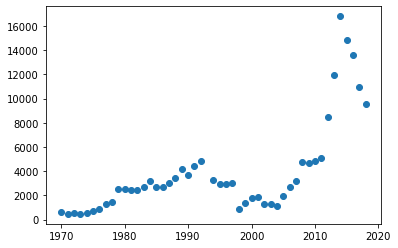

In [9]:
plot.scatter("iyear", "attack_counts", data = global_terrorism_year_counts);

In [10]:
# Looking at this 
# Diffeeent country migh affect this diffeently.
# The first outstanding observation is the spike of terror activities in 2014.
# Can see the steady increase in terrorist activities after 2010. Then e peakk activity in 2014 followeb by a sharp decrease after.
# Still the terror activity numbers are at very high

In [85]:
# number of attacks by country
global_terrorism_country_counts = global_terrorism_data.groupby(['country', 'country_txt']).size().reset_index(name='attack_counts')
global_terrorism_country_counts.head()


,country,country_txt,attack_counts
0,4,Afghanistan,14414
1,5,Albania,79
2,6,Algeria,2624
3,8,Angola,465
4,10,Antigua and Barbuda,1


In [76]:
# Attack type
global_terrorism_attackType = global_terrorism_data.groupby(['attacktype1_txt']).size().reset_index(name='attack_counts')
global_terrorism_attackType

,attacktype1_txt,attack_counts
0,Armed Assault,43683
1,Assassination,19621
2,Bombing/Explosion,90431
3,Facility/Infrastructure Attack,10848
4,Hijacking,657
5,Hostage Taking (Barricade Incident),1019
6,Hostage Taking (Kidnapping),11647
7,Unarmed Assault,1067
8,Unknown,7910


In [92]:
global_terrorism_country_counts.agg(numpy.max)
#global_terrorism_country_counts.agg(numpy.min)
global_terrorism_country_counts['attack_counts'].agg(numpy.min)

1

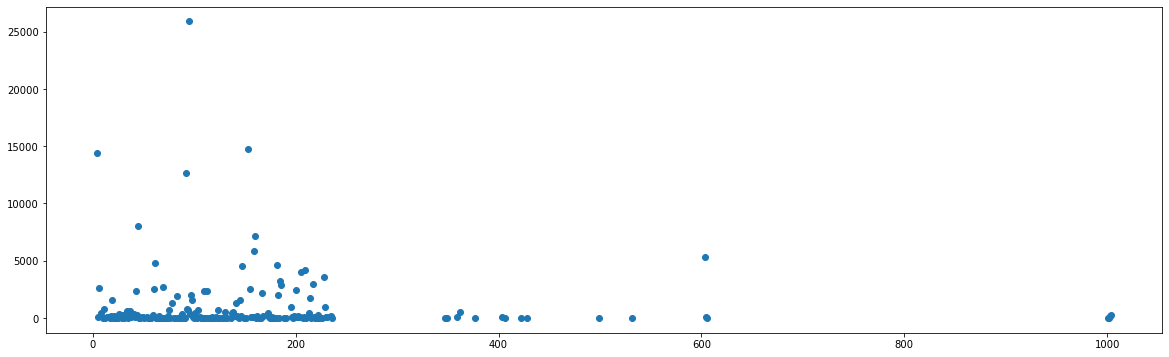

In [55]:
plot.figure(figsize=(20,6))
plot.scatter("country", "attack_counts", data = global_terrorism_country_counts);


In [58]:
global_terrorism_country_counts.agg([numpy.min, numpy.max])

,country,country_txt,attack_counts
amin,4,Afghanistan,1
amax,1004,Zimbabwe,25898


In [65]:
# group by region
global_terrorism_region_counts = global_terrorism_data.groupby(['region', 'region_txt']).size().reset_index(name='attack_counts')
global_terrorism_region_counts.head(12)

,region,region_txt,attack_counts
0,1,North America,3573
1,2,Central America & Caribbean,9359
2,3,South America,18422
3,4,East Asia,800
4,5,Southeast Asia,12831
5,6,South Asia,47769
6,7,Central Asia,556
7,8,Western Europe,16686
8,9,Eastern Europe,5190
9,10,Middle East & North Africa,52196


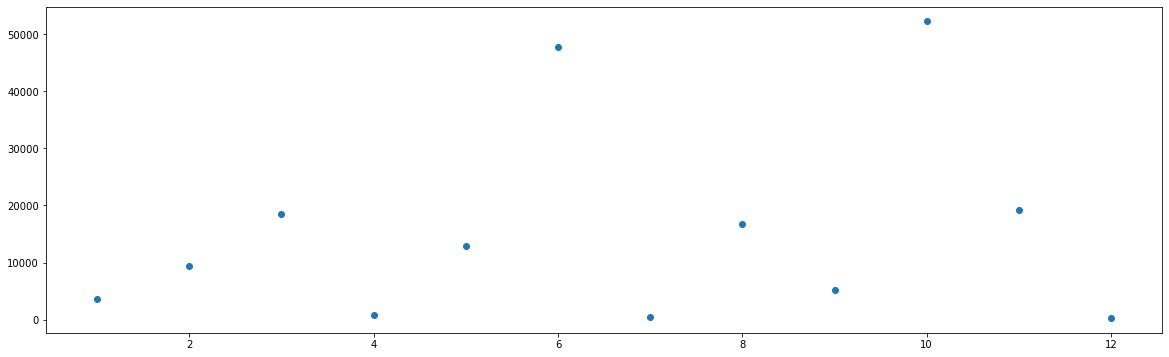

In [67]:
plot.figure(figsize=(20,6))
plot.scatter("region", "attack_counts", data = global_terrorism_region_counts);

In [71]:
region_terrorism_year_counts = global_terrorism_data.groupby(['iyear', 'region_txt']).size().reset_index(name='attack_counts')
region_terrorism_year_counts.head(10)

,iyear,region_txt,attack_counts
0,1970,Australasia & Oceania,1
1,1970,Central America & Caribbean,6
2,1970,East Asia,2
3,1970,Eastern Europe,12
4,1970,Middle East & North Africa,28
5,1970,North America,472
6,1970,South America,63
7,1970,South Asia,1
8,1970,Southeast Asia,9
9,1970,Western Europe,49


In [74]:
terrorism_year_counts = global_terrorism_data.groupby('iyear')
terrorism_data_2014 = terrorism_year_counts.get_group(2014)
terrorism_data_1992 = terrorism_year_counts.get_group(1992)

In [11]:
X = global_terrorism_year_counts.iyear.values
Y = global_terrorism_year_counts.attack_counts.values
X = X.reshape(-1, 1)
#Y = Y.reshape(-1, 1)
reg = LinearRegression().fit(X, Y)

reg.score(X, Y)
#reg.coef_

0.47091829906167015

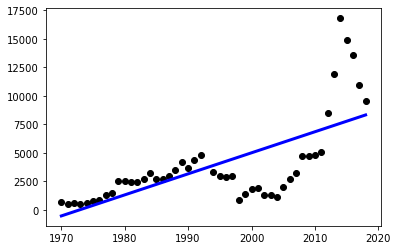

In [12]:
plot.scatter(X, Y,  color='black')
plot.plot(X, reg.predict(X), color='blue', linewidth=3)
plot.show()

In [ ]:
# Lets better understand this by looking at the terror activities by country per year.

In [ ]:
#COUNT HOW MANY OF EACH TYPE OF attack OCCUR SO WE CAN PICK TOP 5 TO PLOT ON HEAT MAPS AND HISTOGRAMS

attack_types = sorted(df_tidied["TYPE"].unique()) #GET ALL UNIQUE TYPES IN DATAFRAME
types_with_counts = [] #STORE EACH TYPE'S COUNTS IN AN ARRAY

temp_df = df_tidied.copy() #DONT WANT TO GROUPBY IN THE ORIGINAL DATAFRAME SO I MADE A TEMPORARY DATAFRAME

i = 0
for ele in types: #COUNT THE NUMBER OF OFFENSE FOR EACH TYPE BY GROUPING IN THE DATAFRAME AND STORING IT AS A TUPLE
    #PANDAS WILL COUNT BY AN ATTRIBUTE FOR YOU, AND FILL IN THAT VALUE IN ALL COLUMNS, SO GRAB THOSE VALUES AND STORE THEM AS A TUPLE INTO A LIST
    types_with_counts.append((ele, temp_df.groupby('TYPE').count()['DISPOSITION'][0:].values[i])) 
    i += 1

#NOW I HAVE A LIST IN FORM: (TYPE_OF_CRIME, FREQUENCY)
types_with_counts = sorted(types_with_counts, key=lambda x: x[1], reverse = True)
types_with_counts[0:10]

In [37]:
country_terrorism_year_counts = global_terrorism_data.groupby(['iyear', 'country_txt']).size().reset_index(name='attack_counts')

In [38]:
# What is its size?

In [39]:
country_terrorism_year_counts.shape
#country_terrorism_year_counts.describe()

(3816, 3)

In [40]:
# Lets take a look at the data

In [41]:
country_terrorism_year_counts.head(10)

,iyear,country_txt,attack_counts
0,1970,Argentina,20
1,1970,Australia,1
2,1970,Belgium,1
3,1970,Brazil,6
4,1970,Canada,2
5,1970,Colombia,1
6,1970,Dominican Republic,2
7,1970,East Germany (GDR),12
8,1970,Egypt,1
9,1970,Greece,3


In [42]:
country_terrorism_year_counts.tail(10)

,iyear,country_txt,attack_counts
3806,2018,Uganda,10
3807,2018,Ukraine,34
3808,2018,United Kingdom,100
3809,2018,United States,67
3810,2018,Venezuela,12
3811,2018,Vietnam,1
3812,2018,West Bank and Gaza Strip,117
3813,2018,Western Sahara,2
3814,2018,Yemen,322
3815,2018,Zimbabwe,2


In [36]:
country_terrorism_year_counts.agg([numpy.min, numpy.max])

ValueError: must supply a tuple to get_group with multiple grouping keys

In [9]:
# Lets quicly glance at the terrorism on the global map. We will use folium for visualization.

In [8]:
# Initialize the global map using foolium
latitude = 0.0
longitude = -100
global_map = folium.Map(location=[latitude, longitude], zoom_start=2)
global_map = MarkerCluster().add_to(global_map)

In [11]:
size = 1000
for each in global_terrorism_data[0:size].iterrows():
    folium.Marker([each[1]['latitude'],each[1]['longitude']],
                      popup=('City: ' + str(each[1]['city']).capitalize() + '<br>'
                             'Target: ' + str(each[1]['targtype1_txt']) + '<br>'
                             'Year: ' + str(each[1]['iyear']).capitalize() + '<br>')
                 ).add_to(global_map)

In [12]:
global_map

In [ ]:
# Adding our data point as an interactive marker.

for i in range (0, 5), lat, lon, city, targtype1_txt in zip(global_terrorism_data1["latitude"], global_terrorism_data1["longitude"],
                                         global_terrorism_data1["city"], global_terrorism_data1["targtype1_txt"]):
    folium.Marker([lat, lon],
                 popup = ('City: ' + str(city).capitalize() + '<br>'
                             'Target: ' + str(targtype1_txt) + '<br>'
                         )
                 ).add_to(global_map)

In [ ]:
global_map